In [1]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
import qutip as q
import onix.models.hyperfine as hyperfine

%matplotlib ipympl

<h2>Lindblad Master Equation</h2>

tttttttttttt

$ \dot{\rho} = -i[H,\rho] + \sum_i C_i\rho C_i^\dagger - \frac{1}{2}\{C_i^\dagger C_i,\rho\}$

tttttttttttttttttt

$H(t) = H_0(t) + H_{\mathrm{lm,opt}}(t) + H_{\mathrm{lm,rf}}(t)$

In [170]:
class Simulation:
    """N level simulation.

        Args:
            sequence: a sequence list in the form of [(pulse1, ...), (pulse2, ...), ....] using:
                OPTICAL PULSES ("optical"  , transition     , duration (us))
                RF PULSES      ("rf"       , offset (MHz)   , duration (us))
                DELAY          ("delay"    , duration (us)                 )
            states_g: the ground states used in the simulation. Default: all 6 states.
            states_e: the excited states used in the simulation. Default: all 6 states. Use [] for none.
            states_0: the ground states in rho0.
            B_field: the static magnetic field in units of Gauss.

    """
    def __init__(
        self, 
        sequence:   list = [],
        states_g:   list = ["a", "a'", "b", "b'", "c", "c'"], 
        states_e:   list = ["a", "a'", "b", "b'", "c", "c'"],
        states_g_0: list = ["a", "a'", "b", "b'", "c", "c'"],
        states_e_0: list = [],
        B_field: float = 200e-4,
    ):
        self._order_g = ["a'", "a", "b'", "b", "c'", "c"]
        self._order_e = ["c'", "c", "b'", "b", "a'", "a"]

        # Check input states
        for state in states_g + states_e:
            if state not in self._order_g:
                raise ValueError("Invalid input state.")

        # Check empty sequence
        if not sequence:
            raise ValueError("Empty sequence.")
            
        # Input states
        self._states_g = states_g
        self._states_e = states_e
        self._states_g_0 = states_g_0
        self._states_e_0 = states_e_0
        self._N = len(set(states_g)) + len(set(states_e))

        # Static B field
        self.B_field = B_field
        
        # Basis
        self.basis = self._set_basis()

        # Energies
        self.energies = self._set_energies()

        # Sequence
        self.sequence = sequence
        
    def _set_basis(self):
        """Returns the basis of the N levels used as an ordered dictionary using the global order.
        """
        basis = {}
        c = 0
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                basis[term] = {}
            for state in order_list:
                if state in term_list:
                    basis[term][state] = q.basis(self._N, c)
                    c += 1
        return basis

    def _set_energies(self):
        """Returns the energies of the N levels used as an ordered dictionary using the global order.
        """
        energies = {}
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                energies[term] = {}
                term_hyperfine = hyperfine.states[term]
                term_hyperfine._Hamiltonian = term_hyperfine.H_total(self.B_field)
                energies_list, _ = term_hyperfine.energies_and_eigenstates()
                for ss, state in enumerate(order_list):
                    if state in term_list:
                        energies[term][state] = energies_list[ss]
        return energies

    def _get_c_ops(self, gamma):
        """ Gets the collapse operators. (Currently only for spontaneous emission).

            Note: uses collapse operators as defined by QuTiP: C = sqrt(gamma) * A where A is the typical jump operator.
    
            Args:
                gamma: the rate of spontaneous emission. Currently uses one global gamma
            
            TODO: include unique gammas for each transition.
            TODO: include dephasing collapse operators.
        """
        c_ops = []
        N_g = len(set(self._states_g))
        gammas = {
        }
        if self._states_e:
            sum_basis_g = 0
            for state in self.basis["7F0"]:
                sum_basis_g += self.basis["7F0"][state]
            for state in self.basis["5D0"]:
                c_ops.append(np.sqrt(gamma / N_g) * sum_basis_g * self.basis["5D0"][state].dag())
        return c_ops

    def _get_rho0(self):
        """Sets the initial conditions of the populations.
        """
        counter = 0
        sum_basis_0 = 0
        
        for state in self.basis["7F0"]:
            if state in self._states_g_0:
                sum_basis_0 += self.basis["7F0"][state] * self.basis["7F0"][state].dag()
                counter += 1

        if self._states_e:
            for state in self.basis["5D0"]:
                if state in self._states_e_0:
                    sum_basis_0 += self.basis["5D0"][state] * self.basis["5D0"][state].dag()
                    counter += 1
                    
        return sum_basis_0 / counter
        
    def _get_H_0(self):
        """Sets the non-interacting Hamiltonian using the energies.
        """
        return q.Qobj(np.diag([2 * pi * self.energies[term][state] for term, states in self.energies.items() for state, _ in states.items()]))
        
    def _get_H_det(self):
        """Sum in 5D0 outter products of bases.
        """
        H_det = 0
        if self._states_e:
            for state_e in self.basis["5D0"]:
                H_det += self.basis["5D0"][state_e] * self.basis["5D0"][state_e].dag()
        return H_det
        
    def _get_H_opt(self):
        """Sets the optical interaction Hamiltonian.
        """
        Omega_opt = 0.2 # MHz
        H_opt = q.Qobj(np.zeros((self._N, self._N)))
        if self._states_e:
            for state_g in self.basis["7F0"]:
                for state_e in self.basis["5D0"]:
                    H_i = self.basis["7F0"][state_g] * self.basis["5D0"][state_e].dag() + self.basis["5D0"][state_e] * self.basis["7F0"][state_g].dag()
                    H_opt += 2 * pi * Omega_opt / 2 * H_i
        return H_opt

    def _get_H_rf(self):
        """Sets the RF interaction Hamiltonian. No RWA used for RF transitions. Rabi frequencies defined inside.
        """
        N_g = len(set(self._states_g))
        H_rf = 0

        # RF Rabi frequency table
        # Rabi frequency in MHz
        rf_rabi_freqs = {
            "a" : {
                "b" : 12e-3,
                "b'": 6e-3,
                "c" : 0,
                "c'": 0,
            },
            "a'": {
                "b" : 6e-3,
                "b'": 12e-3,
                "c" : 0,
                "c'": 0,
            },
            "b" : {
                "c" : 0,
                "c'": 0,
            },
            "b'": {
                "c" : 0,
                "c'": 0,   
            }
        }
        for state_1 in self.basis["7F0"]:
            for state_2 in self.basis["7F0"]:
                if state_1 in rf_rabi_freqs.keys() and state_2 in rf_rabi_freqs[state_1].keys():
                    H_i = self.basis["7F0"][state_1] * self.basis["7F0"][state_2].dag() + self.basis["7F0"][state_2] * self.basis["7F0"][state_1].dag()
                    H_rf += 2 * pi * rf_rabi_freqs[state_1][state_2] * H_i
        return H_rf

    def _rectangular_pulse(self, x, duration, start_time):
        """Simple rectangular pulse.

        Args:
            x: input parameter (i.e. time) (us)
            duration: total duration of pulse (us)
            start_time: start time of pulse (us)
        """
        start = start_time
        end = start_time + duration
        if x >= start and x < end:
            return 1
        else:
            return 0
        
    def _pulse(self, pulse_type, transition = "", offset = 0, duration = 0, start_time = 0):   
        """Setup pulse Hamiltonian.

            Args:
                pulse_type: the type of pulse: "optical", "rf", "delay"
                transition: used for optical pulses, e.g. "ab"
                offset: used for rf pulses, e.g. 0.2 (in MHz)
                duration: duration of pulse
                start_time: start time of pulse

            Returns the Hamiltonian for the pulse interval.
        """
        if pulse_type == "optical":
            state_g = transition[0]
            state_e = transition[1]
        
            H_opt = self._get_H_opt()
            H_det = self._get_H_det()

            average_energy_g = (self.energies["7F0"][state_g] + self.energies["7F0"][state_g + "'"]) / 2
            average_energy_e = (self.energies["5D0"][state_e] + self.energies["5D0"][state_e + "'"]) / 2
            detuning = abs(average_energy_e - average_energy_g)
            
            H_opt_det = H_opt - detuning * H_det
            return [H_opt_det, lambda t, args: self._rectangular_pulse(t, duration, start_time)]
            
        if pulse_type == "rf":
            omega = 2 * pi * (119.2 + offset) # MHz
            H_rf = self._get_H_rf()
            
            return [H_rf, lambda t, args: np.cos(omega * t) * self._rectangular_pulse(t, duration, start_time)]   

    def _get_H_total(self):
        """Uses the sequence to build the total Hamiltonian
        """
        H_total = [[self._get_H_0(), lambda t, args: 1]]
        total_time = 0
            
        for seq in self.sequence:
            if seq[0] == "optical":
                H_total.append(self._pulse(seq[0], transition = seq[1], duration = seq[2], start_time = total_time))
                total_time += seq[2]
                
            if seq[0] == "rf":
                H_total.append(self._pulse(seq[0], offset = seq[1], duration = seq[2], start_time = total_time))
                total_time += seq[2]
                
            if seq[0] == "delay":
                total_time += seq[1]
                
        return H_total, total_time
        
    def plot_simulation(self):
        """Plot simulation for all states.
        
           TODO: plots for any input state config
        """
        fig, axs = plt.subplots(2, 6, figsize=(12, 6))
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                axs[ii, jj].plot(self.ts, self.results.expect[ii * 6 + jj], label = f"{i}, {j}", linewidth=2)
                axs[ii, jj].set_title(f"{i}, {j}")
                axs[ii, jj].set_ylim([-1e-2, 1 + 1e-2])
                axs[ii, jj].set_xlim([0, np.max(self.ts)])
                axs[ii, jj].set_yticklabels([])
                axs[ii, jj].set_xlabel("time (us)")
        plt.tight_layout()
        plt.show()

    def single_plot_simulation(self):
        """Plot simulation for all states in 1 plot.
        
           TODO: plots for any input state config
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        linestyles = ["solid", "dotted"]
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                # TODO: use input state length
                ax.plot(self.ts, self.results.expect[ii * 6 + jj], label = f"{i}, {j}", linewidth = 2, linestyle = linestyles[ii])
                ax.set_ylim([-1e-2, 1 + 1e-2])
                ax.set_xlim([0, np.max(self.ts)])
                ax.set_xlabel("time (us)")
                ax.set_ylabel("population")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def summed_plot_simulation(self):
        """Plot simulation for all states in 1 plot.
        
           TODO: plots for any input state config
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        sum = 0
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                sum += self.results.expect[ii * 6 + jj]
        ax.plot(self.ts, sum)
        ax.set_ylim([1 - 1e-9, 1 + 1e-9])
        ax.set_xlim([0, np.max(self.ts)])
        ax.set_xlabel("time (us)")
        ax.set_ylabel("total population")
        plt.tight_layout()
        plt.show()
        
    def run_simulation(self, iters: int = 1000):
        """Run the QuTiP simulation.

            TODO: fix to have any input state config
        """
        H_total, total_time = self._get_H_total()
        ts = np.linspace(0, total_time, iters)
        
        lifetime_s = 2e-3
        decay_rate = 1 / lifetime_s
        decay_rate_MHz = decay_rate / 1e6
        
        rho_0 = self._get_rho0()
        c_ops = self._get_c_ops(decay_rate_MHz)
        e_ops = [self.basis[i][j] * self.basis[i][j].dag() for i, iv in self.basis.items() for j, _ in iv.items()]
        progress_bar = True
        options = q.Options(nsteps = 2000000, atol = 1e-9, rtol = 1e-8)
        
        self.results = q.mesolve(H_total, rho_0, ts, c_ops = c_ops, e_ops = e_ops, progress_bar = progress_bar, options = options)
        self.ts = ts

In [3]:
# q.mesolve?

<h3>List of ab RF offsets</h3>

In [4]:
simulation = Simulation(sequence = [()])

delta_abarbbar = simulation.energies["7F0"]["b'"] - simulation.energies["7F0"]["a'"] - 119.2
delta_abarb    = simulation.energies["7F0"]["b"] - simulation.energies["7F0"]["a'"] - 119.2
delta_abbar    = simulation.energies["7F0"]["b'"] - simulation.energies["7F0"]["a"] - 119.2
delta_ab       = simulation.energies["7F0"]["b"] - simulation.energies["7F0"]["a"] - 119.2

print(f"a  b' --> {delta_abbar}")
print(f"a  b  --> {delta_ab}")
print(f"a' b' --> {delta_abarbbar}")
print(f"a' b  --> {delta_abarb}")

a  b' --> -0.24286609570783924
a  b  --> -0.11656699091037126
a' b' --> -0.01531450959195979
a' b  --> 0.11098459520550819


10.0%. Run time:   2.48s. Est. time left: 00:00:00:22
20.0%. Run time:   6.97s. Est. time left: 00:00:00:27
30.0%. Run time:  13.19s. Est. time left: 00:00:00:30
40.0%. Run time:  19.82s. Est. time left: 00:00:00:29
50.0%. Run time:  26.38s. Est. time left: 00:00:00:26
60.0%. Run time:  33.07s. Est. time left: 00:00:00:22
70.0%. Run time:  39.45s. Est. time left: 00:00:00:16
80.0%. Run time:  45.84s. Est. time left: 00:00:00:11
90.0%. Run time:  50.49s. Est. time left: 00:00:00:05
Total run time:  55.03s


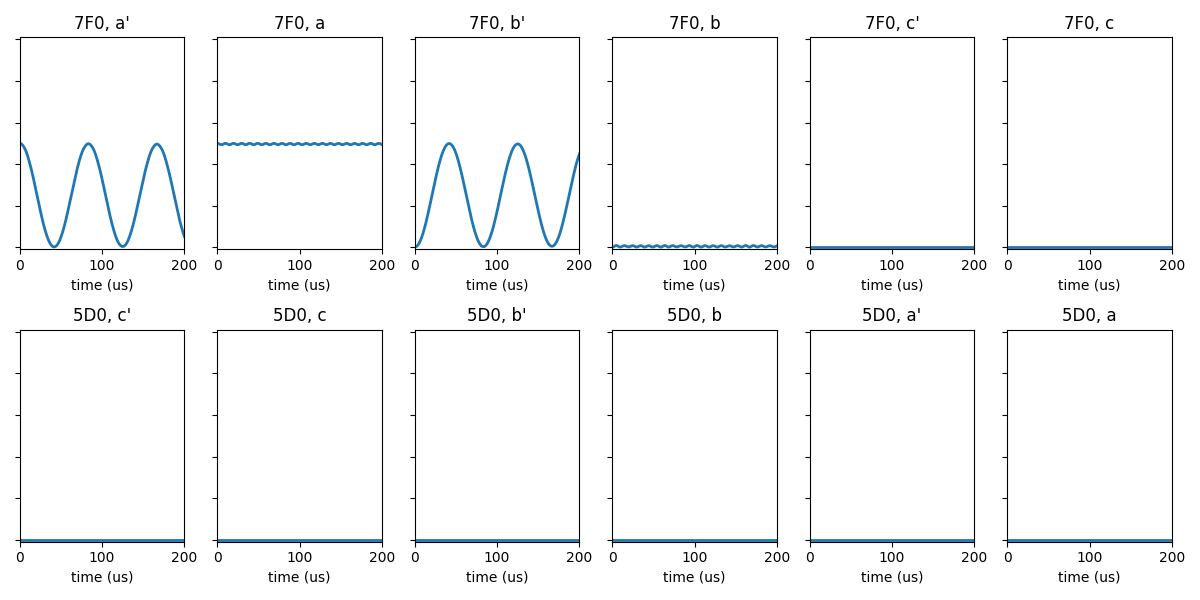

In [171]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

# sequence.append(("optical", "bb", 1000))
for i in range(1):
    # sequence.append(("optical", "ca", 1.5))
    # sequence.append(("optical", "ac", 1.5))
    sequence.append(("rf", -0.01531, 200))
    # sequence.append(("delay", 100))

simulation = Simulation(states_g_0 = ["a", "a'"], sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

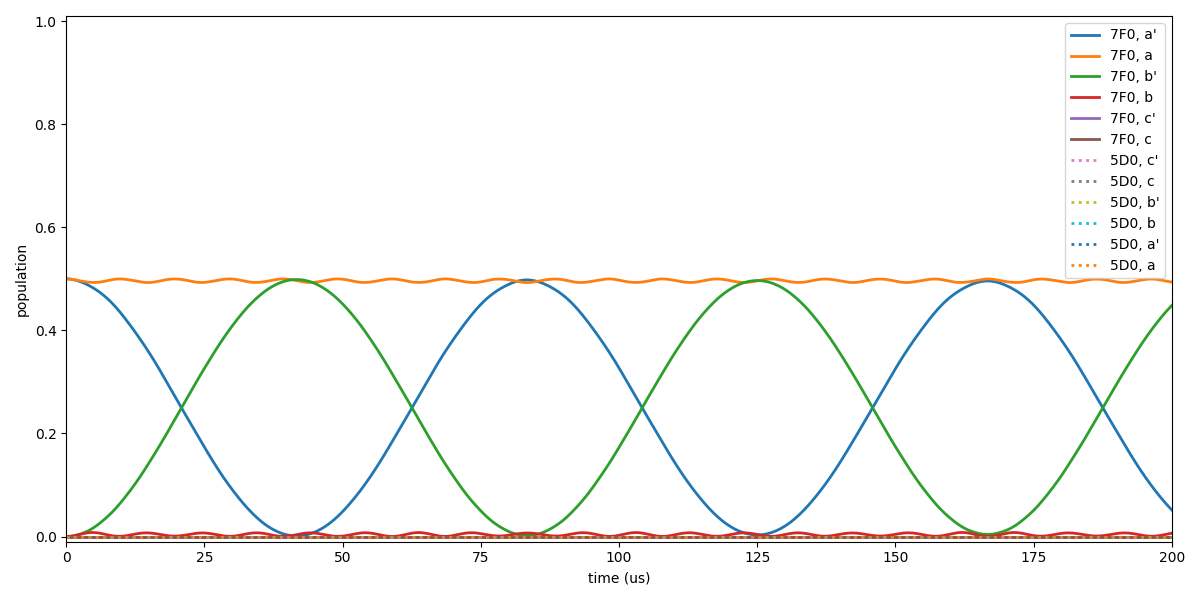

In [172]:
simulation.single_plot_simulation()

10.0%. Run time:   2.58s. Est. time left: 00:00:00:23
20.0%. Run time:   7.69s. Est. time left: 00:00:00:30
30.0%. Run time:  11.79s. Est. time left: 00:00:00:27
40.0%. Run time:  15.93s. Est. time left: 00:00:00:23
50.0%. Run time:  18.28s. Est. time left: 00:00:00:18
60.0%. Run time:  21.85s. Est. time left: 00:00:00:14
70.0%. Run time:  25.07s. Est. time left: 00:00:00:10
80.0%. Run time:  29.58s. Est. time left: 00:00:00:07
90.0%. Run time:  33.94s. Est. time left: 00:00:00:03
Total run time:  38.20s


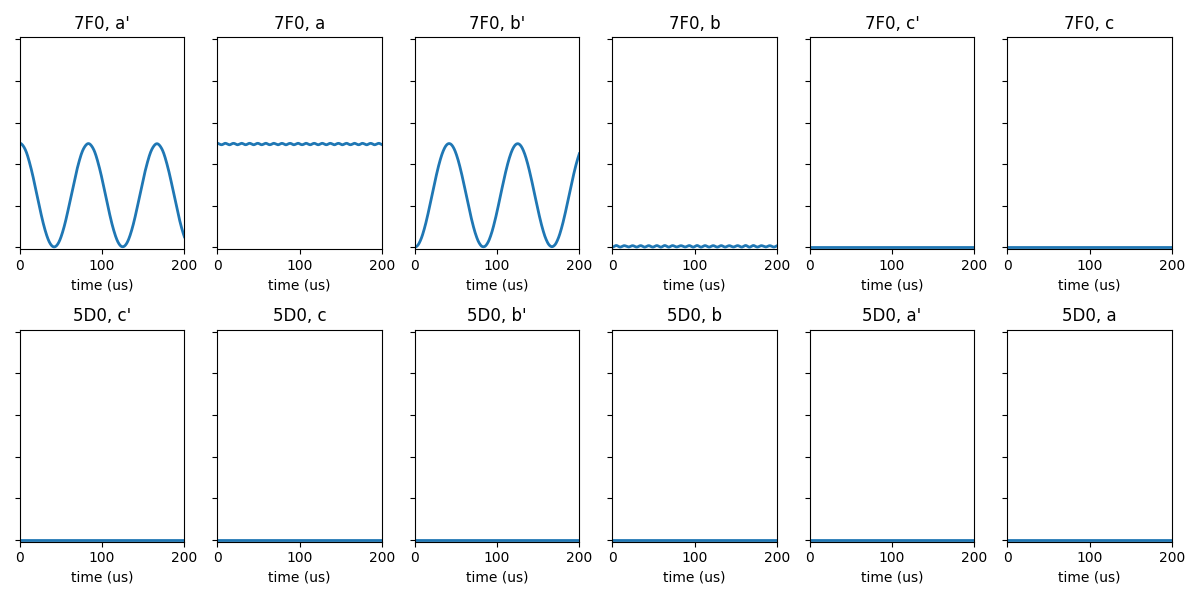

In [173]:
sequence = []
sequence.append(("rf", -0.01531450959195979, 200))

simulation = Simulation(states_g_0 = ["a", "a'"], sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

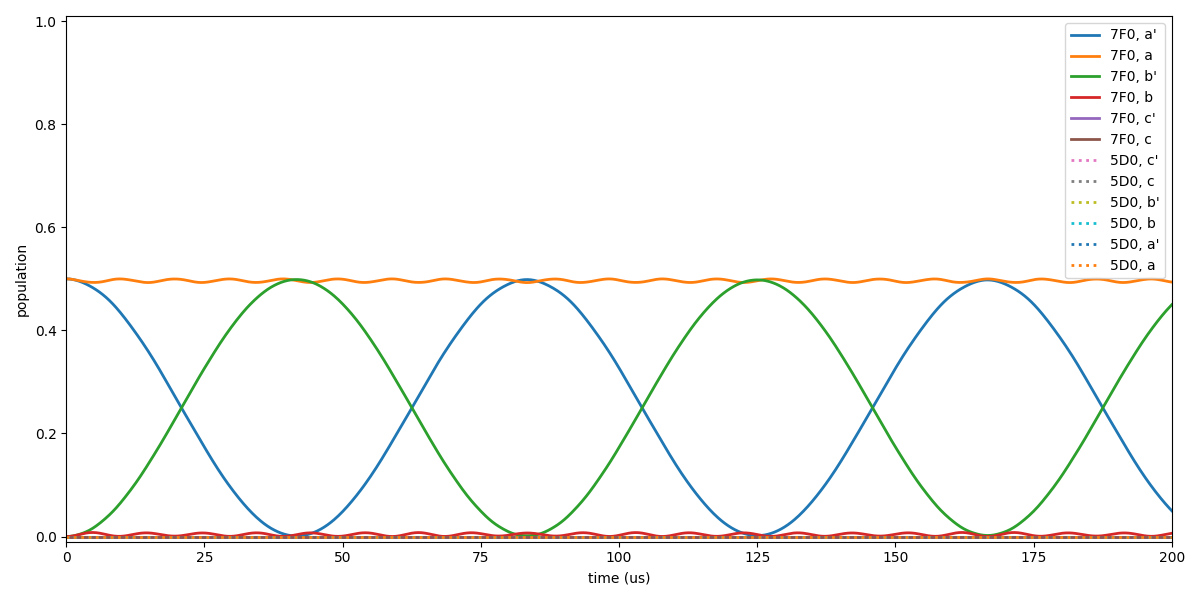

In [174]:
simulation.single_plot_simulation()

In [ ]:
sequence = []

sequence.append(("optical", "bb", 1.5))
sequence.append(("optical", "ac", 1.5))
sequence.append(("optical", "ca", 1.5))

sequence.append(("rf", -0.01531450959195979, 1000))
sequence.append(("delay", 500))
sequence.append(("rf", -0.24286609570783924, 1000))

simulation = Simulation(states_g_0 = ["a", "a'"], sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()